In [1]:
import math
import random
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import timedelta
%matplotlib inline

sns.set_style("darkgrid")

from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OrdinalEncoder,
    PowerTransformer,
    FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

seed = 42
random.seed(seed)
np.random.seed(seed)


In [2]:
# Load the dataset
data = pd.read_excel(r'C:\Users\Admin\Desktop\CUSTOMER SEG PYTHON\Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Investigating the dataset
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


(541909, 8)

In [4]:
# Data Cleaning; checking missing values

data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
# Dropping the missing values on the customer Id
data.drop(data[data["CustomerID"].isnull()].index, axis=0, inplace=True)
data["Description"] = data["Description"].fillna("")
data.isnull().sum().sum()

0

In [11]:
#Checking the cleaned data
data.shape

(392361, 8)

In [13]:
# Dropping negative (cancelled) invoices
size_before = len(data)
neg_quantity = data[data["Quantity"] < 0][["CustomerID", "StockCode", "Quantity"]].sort_values("Quantity")
print(f"Negative Quantity: {len(neg_quantity)}")

filtered = data[data["CustomerID"].isin(neg_quantity["CustomerID"])]
filtered = filtered[filtered["StockCode"].isin(neg_quantity["StockCode"])]

pos_counters = []
for idx, series in neg_quantity.iterrows():
    customer = series["CustomerID"]
    code = series["StockCode"]
    quantity = -1 * series["Quantity"]
    counterpart = filtered[(filtered["CustomerID"] == customer) & (filtered["StockCode"] == code) & (filtered["Quantity"] == quantity)]
    pos_counters.extend(counterpart.index.to_list())

to_drop = neg_quantity.index.to_list() + pos_counters
data.drop(to_drop, axis=0, inplace=True)
print(f"Removed {size_before - len(data)} rows from the dataset")

Negative Quantity: 0
Removed 0 rows from the dataset


In [15]:
(data["Quantity"] <= 0).sum()

0

In [18]:
#Dropping values where unit price equals zero
data.drop(data[data["UnitPrice"] == 0].index, axis=0, inplace=True)

In [19]:
# extracting time related features from InvoiceDate

data["InvoiceDateDay"] = data["InvoiceDate"].dt.date
data["InvoiceDateTime"] = data["InvoiceDate"].dt.time
data["InvoiceYear"] = data["InvoiceDate"].dt.year
data["InvoiceMonth"] = data["InvoiceDate"].dt.month
data["InvoiceMonthName"] = data["InvoiceDate"].dt.month_name()
data["InvoiceDay"] = data["InvoiceDate"].dt.day
data["InvoiceDayName"] = data["InvoiceDate"].dt.day_name()
data["InvoiceDayOfWeek"] = data["InvoiceDate"].dt.day_of_week
data["InvoiceWeekOfYear"] = data["InvoiceDate"].dt.weekofyear
data["InvoiceHour"] = data["InvoiceDate"].dt.hour

data["TotalValue"] = data["Quantity"] * data["UnitPrice"]

In [22]:
# Recency, Frequency and Monetary Value
ref_date = data["InvoiceDateDay"].max() + timedelta(days=1)

data_customers = data.groupby("CustomerID").agg({
    "InvoiceDateDay": lambda x : (ref_date - x.max()).days,
    "InvoiceNo": "count",
    "TotalValue": "sum"
}).rename(columns={
    "InvoiceDateDay": "Recency",
    "InvoiceNo": "Frequency",
    "TotalValue": "MonetaryValue"
})

In [23]:
data_customers.head(10)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
12352.0,37,67,1405.28
12353.0,205,4,89.00
12354.0,233,58,1079.40
12355.0,215,13,459.40
12356.0,23,59,2811.43


In [24]:
data_customers.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4324 entries, 12347.0 to 18287.0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        4324 non-null   int64  
 1   Frequency      4324 non-null   int64  
 2   MonetaryValue  4324 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 135.1 KB


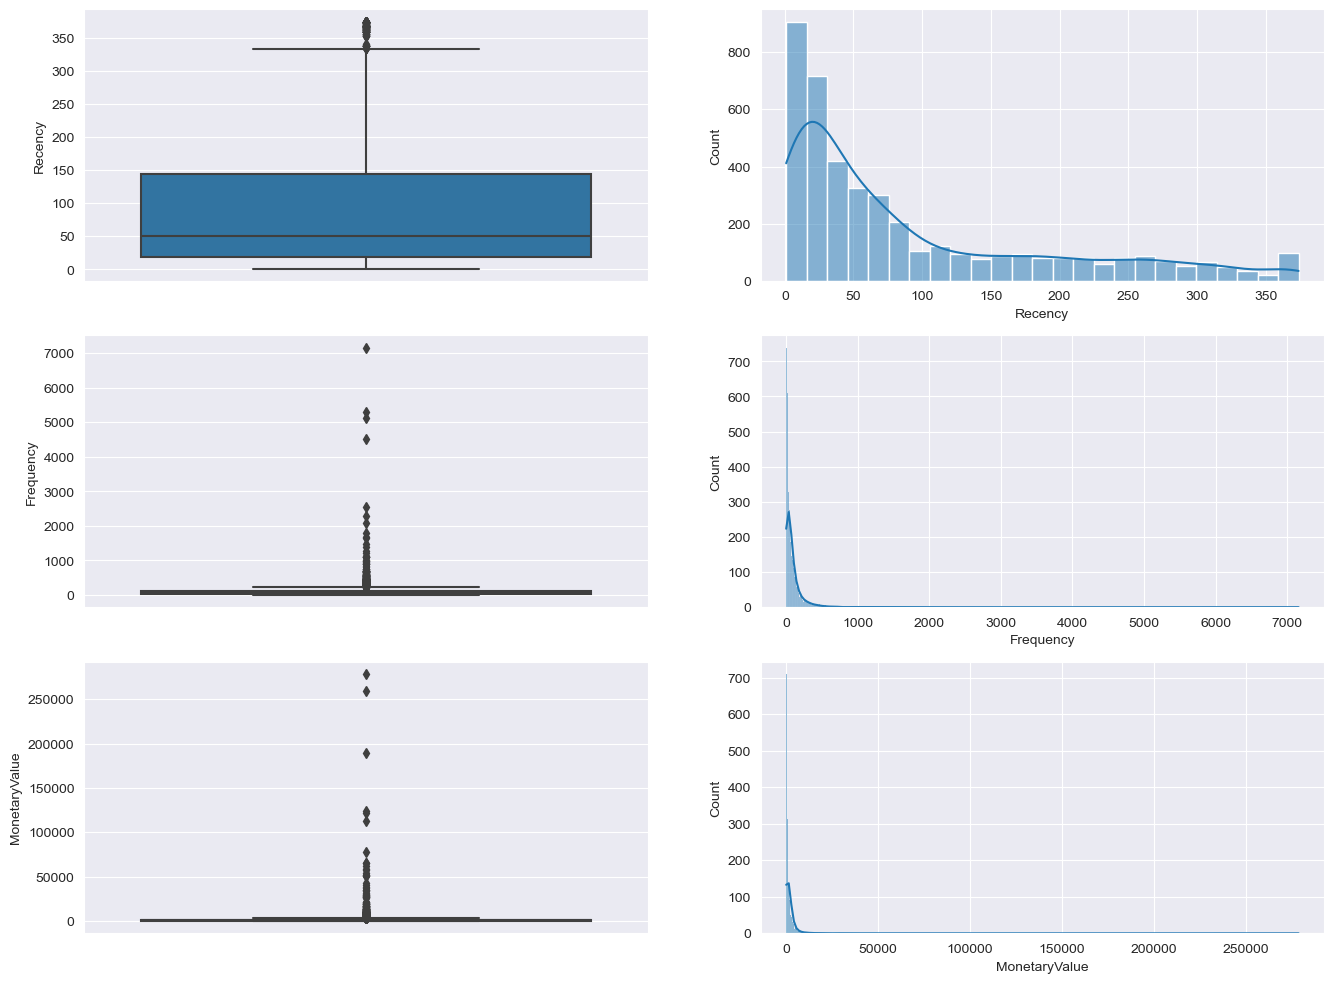

In [25]:
# Removing Outliers
n_cols = len(data_customers.columns)
fig, axes = plt.subplots(n_cols, 2, figsize=(16, n_cols * 4))

for i, col in enumerate(data_customers.columns):
    sns.boxplot(data=data_customers, y=col, ax=axes[i][0])
    sns.histplot(data=data_customers, x=col, kde=True, ax=axes[i][1])

fig.show()

In [27]:
# Eliminating outliners using the IQR technique
def remove_outliers(data, col, threshold=1.5):
    Q1 = np.quantile(data[col], .25)
    Q3 = np.quantile(data[col], .75)
    IQR = Q3 - Q1
    data.drop(data[(data[col] < (Q1 - threshold * IQR)) | (data[col] > (Q3 + threshold * IQR))].index, axis=0, inplace=True)
    
    return data

for col in data_customers.columns:
    size_before = len(data_customers)
    data_customers = remove_outliers(data_customers, col)
    print(f"Removed {size_before - len(data_customers)} outliers from {col}")

Removed 140 outliers from Recency
Removed 363 outliers from Frequency
Removed 316 outliers from MonetaryValue


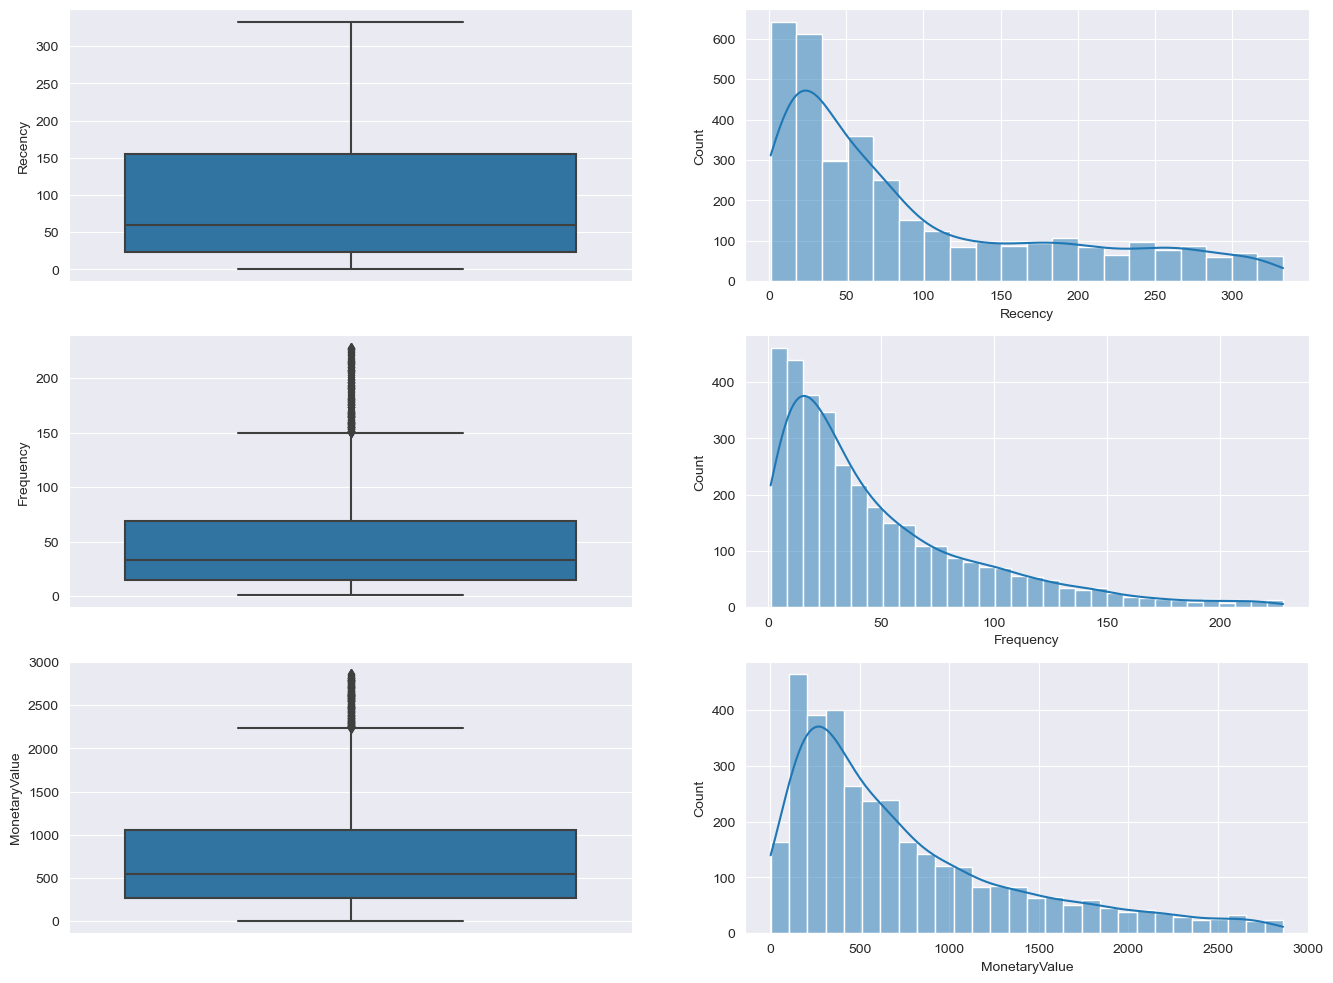

In [28]:
# Data distribution after eliminating outliners
n_cols = len(data_customers.columns)
fig, axes = plt.subplots(n_cols, 2, figsize=(16, n_cols * 4))

for i, col in enumerate(data_customers.columns):
    sns.boxplot(data=data_customers, y=col, ax=axes[i][0])
    sns.histplot(data=data_customers, x=col, kde=True, ax=axes[i][1])

fig.show()

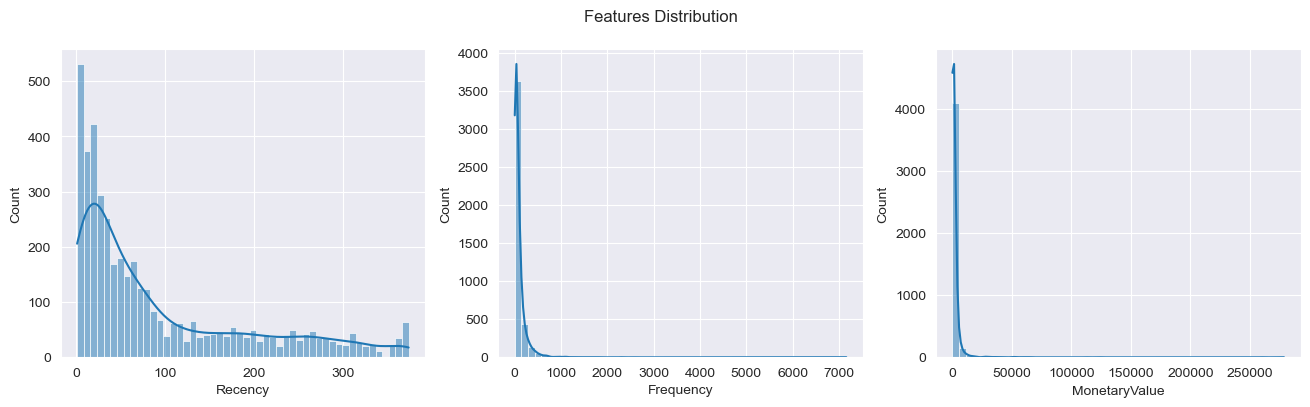

In [33]:
# Exploratory Data Analysis
##Clients RFM
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Features Distribution")
sns.histplot(df_customers["Recency"], bins=50, ax=ax[0], kde=True)
sns.histplot(df_customers["Frequency"], bins=50, ax=ax[1], kde=True)
sns.histplot(df_customers["MonetaryValue"], bins=50, ax=ax[2], kde=True)
fig.show()

In [29]:
# Top 10 clients by revenue
top_10_clients = data_customers["MonetaryValue"].sort_values(ascending=False).head(10)
top_10_clients

CustomerID
12685.0    2863.08
18145.0    2861.55
16928.0    2845.10
15606.0    2840.96
14852.0    2836.69
12473.0    2832.33
14112.0    2816.35
13735.0    2815.29
12356.0    2811.43
18230.0    2810.20
Name: MonetaryValue, dtype: float64

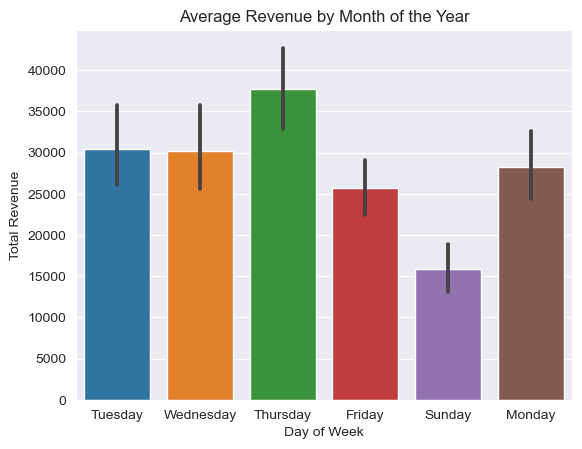

In [30]:
# Revenue by in a Weekly scope
revenue_day = data.groupby(["InvoiceWeekOfYear", "InvoiceDayOfWeek", "InvoiceDayName"])["TotalValue"].sum().reset_index()
revenue_day.groupby(["InvoiceDayOfWeek", "InvoiceDayName"])["TotalValue"].mean().reset_index()
plt.title("Average Revenue by Month of the Year")
sns.barplot(data=revenue_day, x="InvoiceDayName", y="TotalValue")
plt.xlabel("Day of Week")
plt.ylabel("Total Revenue")
plt.show()

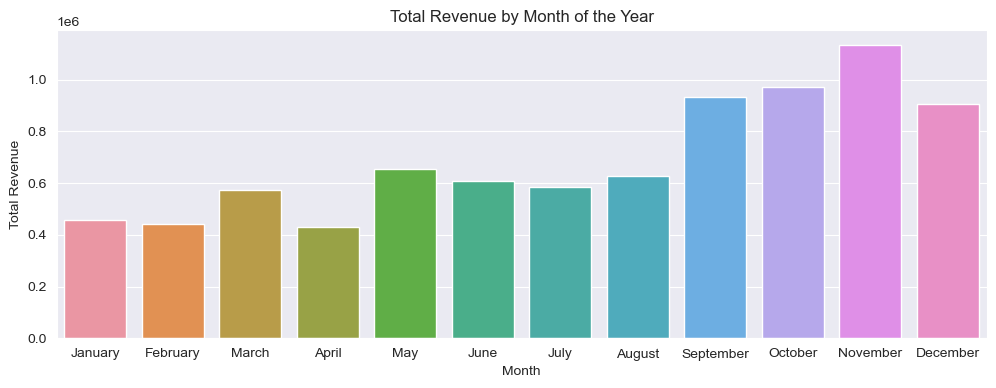

In [31]:
# Revenue by in a Monthly scope
revenue_month = data.groupby(["InvoiceMonth", "InvoiceMonthName"])["TotalValue"].sum().reset_index()
plt.figure(figsize=(12, 4))
plt.title("Total Revenue by Month of the Year")
sns.barplot(data=revenue_month, x="InvoiceMonthName", y="TotalValue")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.show()

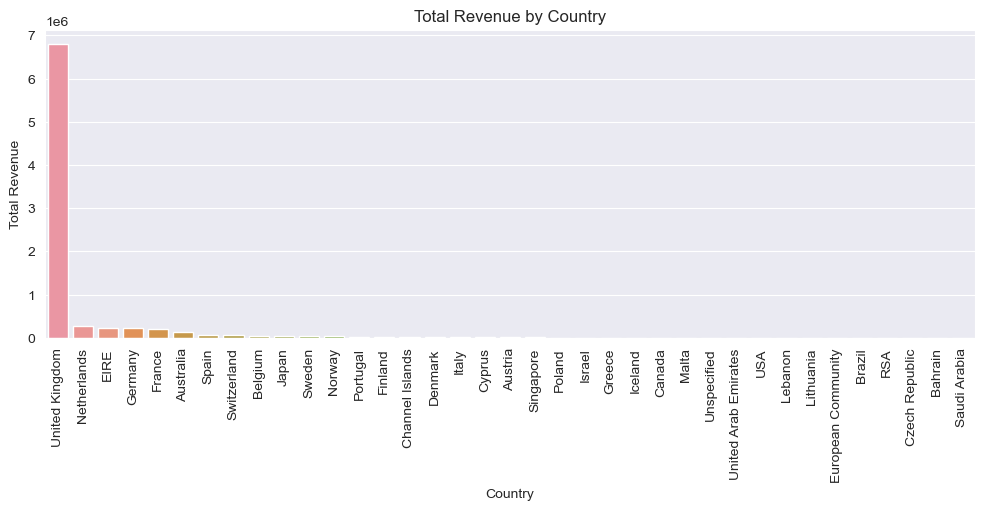

In [32]:
# Revenue per country
country_revenue = data.groupby("Country")["TotalValue"].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 4))
plt.title("Total Revenue by Country")
sns.barplot(data=country_revenue, x="Country", y="TotalValue")
plt.ylabel("Total Revenue")
plt.xticks(rotation=90)
plt.show()

In [34]:
# Clustering
##Preprocessing
df = data_customers
df.shape

(3505, 3)

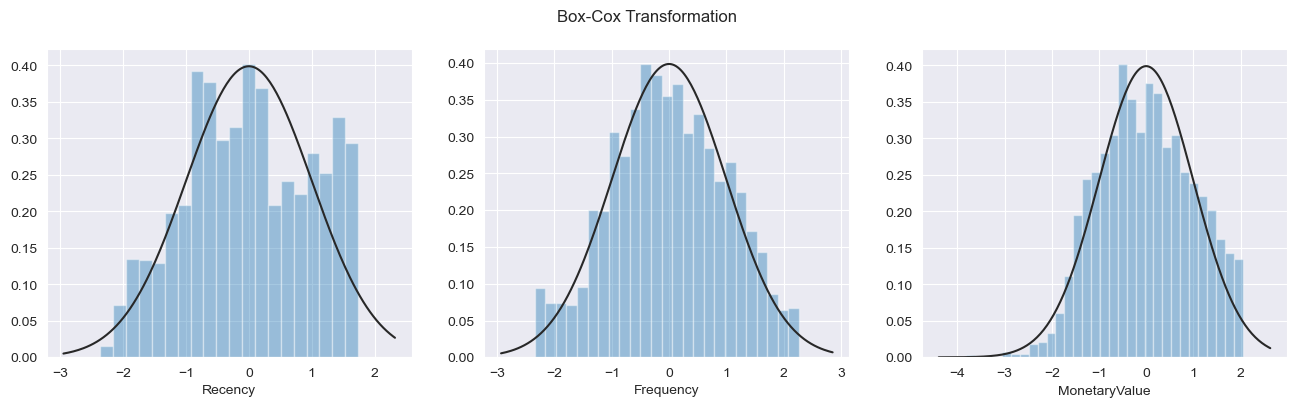

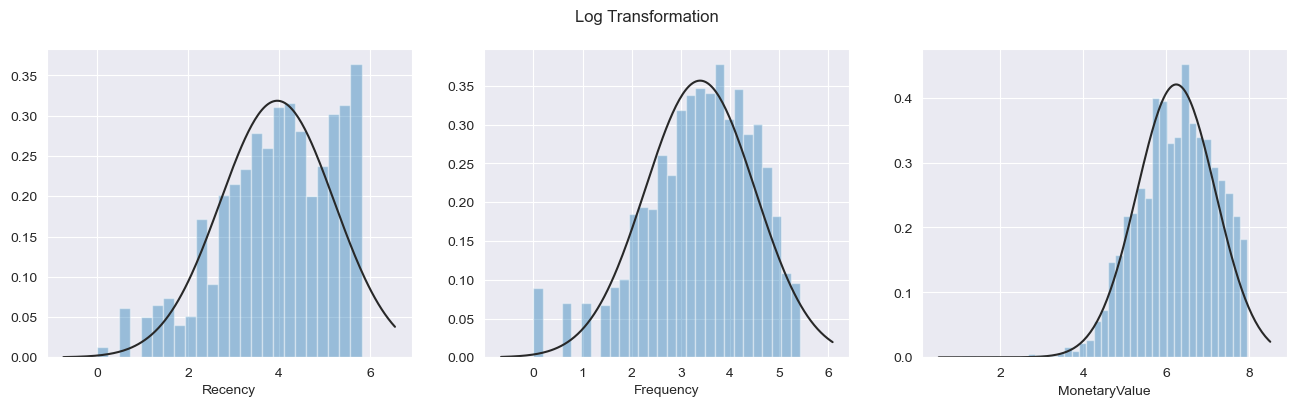

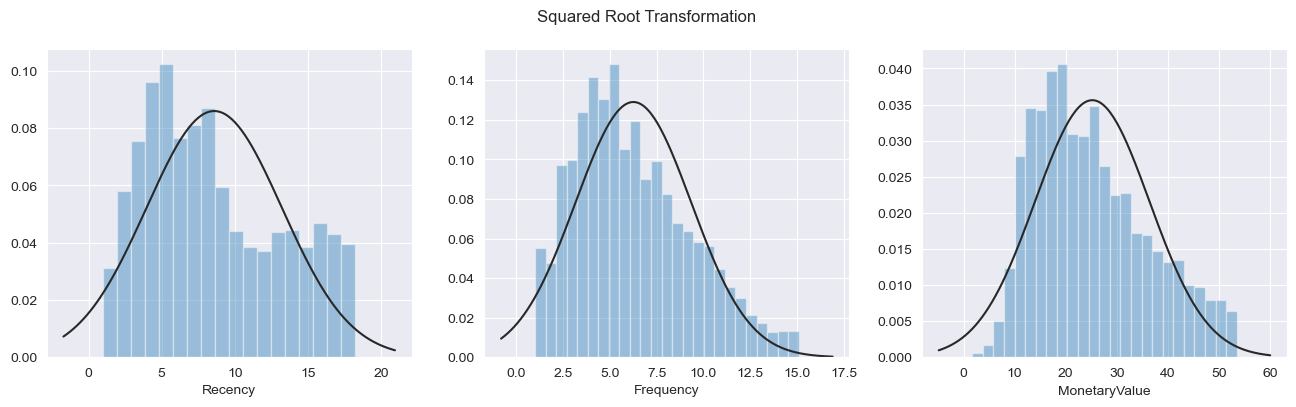

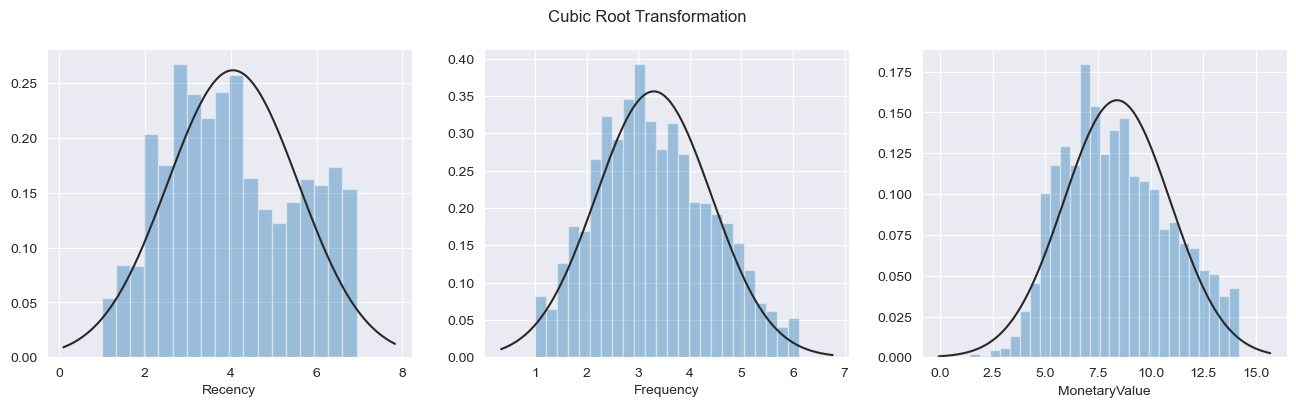

In [37]:
# defining some feature transformers

boxcox_t = PowerTransformer(method="box-cox")
log_t = FunctionTransformer(func=np.log, inverse_func=np.exp)
sqrt_t = FunctionTransformer(func=np.sqrt, inverse_func=lambda x : x ** 2)
cbrt_t = FunctionTransformer(func=np.cbrt, inverse_func=lambda x : x ** 3)

df_boxcox = boxcox_t.fit_transform(df)
df_log = log_t.fit_transform(df).values
df_sqrt = sqrt_t.fit_transform(df).values
df_cbrt = cbrt_t.fit_transform(df).values

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Box-Cox Transformation")
for i in range(3):
    ax = axes[i]
    sns.distplot(df_boxcox[:,i], fit=norm, kde=False, ax=ax)
    ax.set_xlabel(df_customers.columns[i])
    
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Log Transformation")
for i in range(3):
    ax = axes[i]
    sns.distplot(df_log[:,i], fit=norm, kde=False, ax=ax)
    ax.set_xlabel(df_customers.columns[i])
    
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Squared Root Transformation")
for i in range(3):
    ax = axes[i]
    sns.distplot(df_sqrt[:,i], fit=norm, kde=False, ax=ax)
    ax.set_xlabel(df_customers.columns[i])
    
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Cubic Root Transformation")
for i in range(3):
    ax = axes[i]
    sns.distplot(df_cbrt[:,i], fit=norm, kde=False, ax=ax)
    ax.set_xlabel(df_customers.columns[i])


In [38]:
# Standardizing our features with the StandarScaler transformer from scikit-learn
standard_scaler = StandardScaler()

transformers = ColumnTransformer(
    [
        ("boxcox", boxcox_t, ["Frequency"]),
        ("cbrt", cbrt_t, ["Recency", "MonetaryValue"])
    ],
    remainder="passthrough"
)

preprocessing = Pipeline([
    ("transformers", transformers),
    ("scaler", standard_scaler),
])

In [39]:
# Segmenting clients using K-Means
kmeans = KMeans(random_state=seed)

clusterer = Pipeline([
    ("preprocessing", preprocessing),
    ("kmeans", kmeans)
])

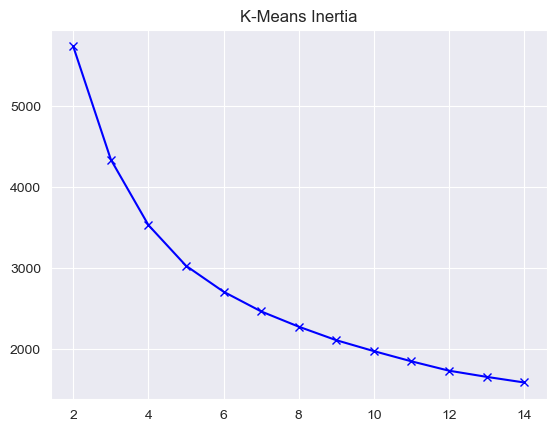

In [42]:
#  Finding Number of Clusters
n_clusters = np.arange(2, 15)
inertia = []
for k in n_clusters:
    kmeans = clusterer.steps[-1][1]
    kmeans.set_params(n_clusters=k)
    clusterer.fit(df)
    inertia.append(kmeans.inertia_)
    
plt.title("K-Means Inertia")
plt.plot(n_clusters, inertia, color="blue", marker="x")
plt.show()

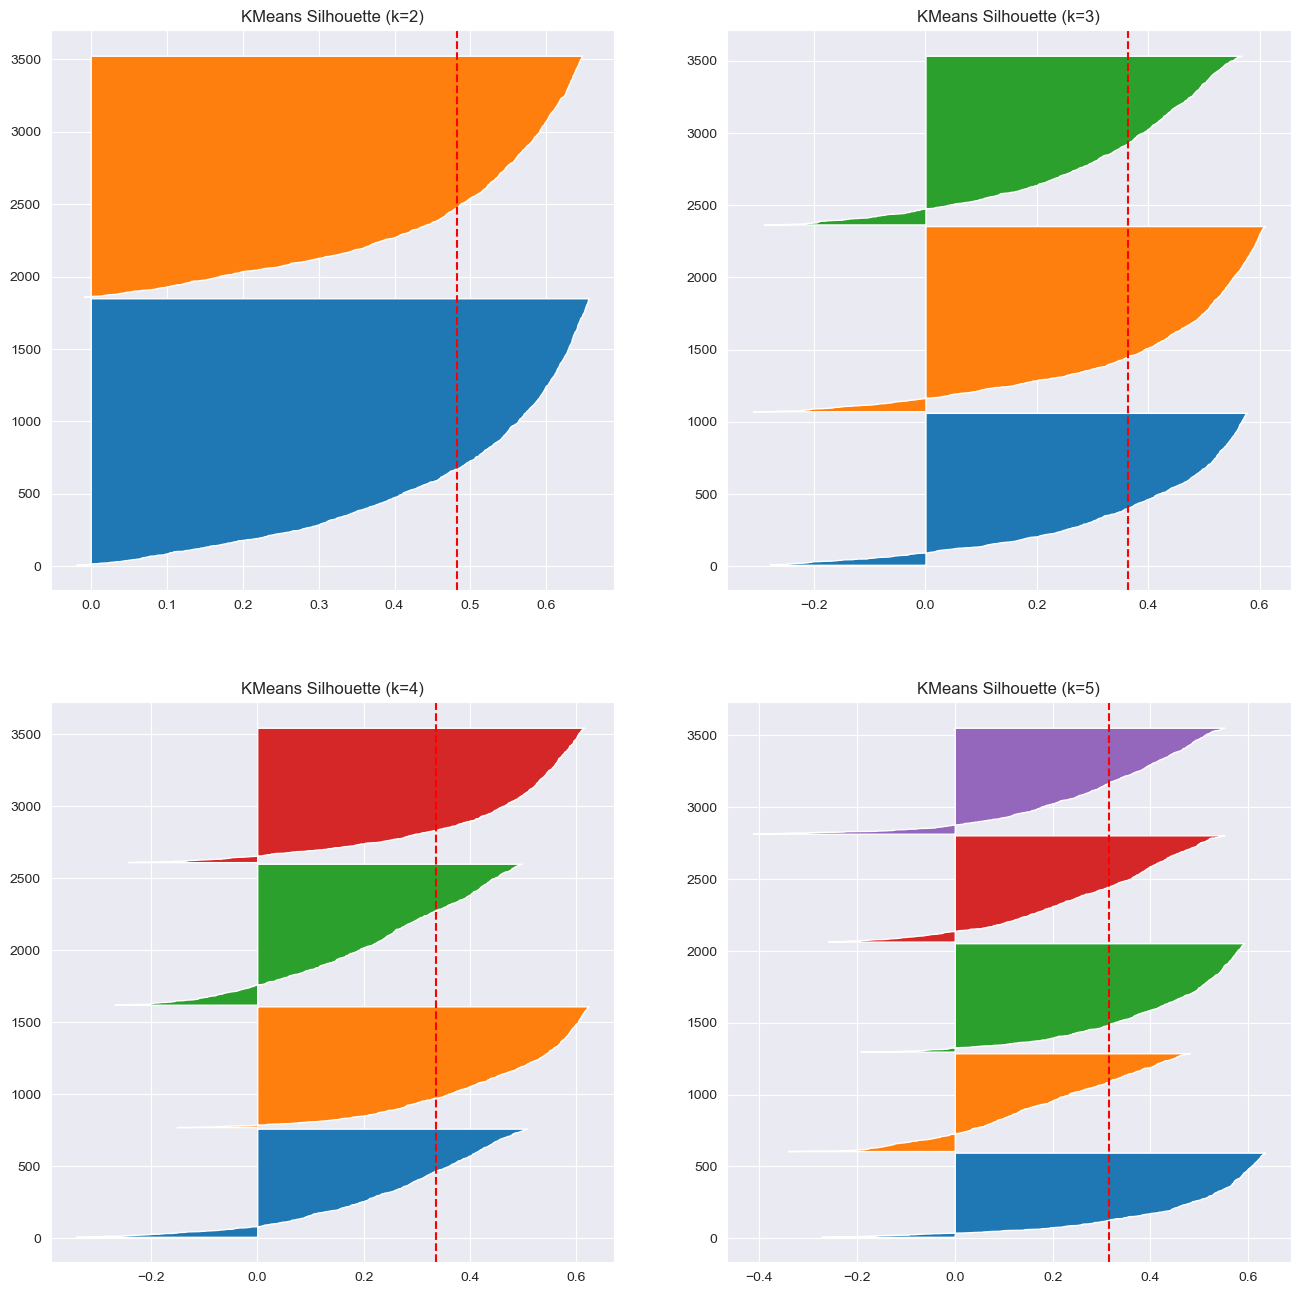

In [47]:
n_clusters = np.arange(2, 6)

def plot_silhouettes(df, labels, ax):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    ax.set_title(f"KMeans Silhouette (k={n_clusters})")
    
    avg_silhouette = silhouette_score(df, labels, random_state=seed)
    clusters_silhouettes = silhouette_samples(df, labels)
    
    y_lower = 10
    for i in (unique_labels):
        cluster_silhouettes = np.sort(clusters_silhouettes[labels == i])
        cluster_size = len(cluster_silhouettes)
        
        y_upper = y_lower + cluster_size
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_silhouettes,
        )
        
        y_lower = y_upper + 10
        
    ax.axvline(avg_silhouette, color="red", linestyle="--")

n_cols = 2
n_rows = math.ceil(len(n_clusters) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 8))
for i, k in enumerate(n_clusters):
    ax = axes[i // n_cols][i % n_cols]
    kmeans = clusterer.steps[-1][1]
    kmeans.set_params(n_clusters=k)
    labels = clusterer.fit_predict(df)
    df_transf = clusterer.transform(df)
    plot_silhouettes(df_transf, labels, ax)
    
    # removing unnecessary axes    
i += 1
while i < (n_rows * n_cols):
    ax = axes[i // n_cols][i % n_cols]
    ax.remove()

In [65]:
#Final Model
kmeans = clusterer.steps[-1][1]
kmeans.set_params(n_clusters=2)
labels = clusterer.fit_predict(df)
data_customers["Label"] = labels
df_customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
12352.0,37,67,1405.28
